In [27]:
import requests
import json
import pandas as pd
from tqdm import tqdm

######Global Params#######
graph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'

col_data_types = {'amount0': float, 'amount1': float, 'logIndex': int, 'liquidity': float,
                  'amount0In': float, 'amount0Out': float, 'amount1In': float, 'amount1Out': float}
#########################

## Query Functionality

In [28]:
def process_query(query, data_field, graph_url):
    """
    Helper function to take a query and retrieve the data.
    query (str): The query to be executed
    data_field (str): The data field to be pulled out
    graph_url (str): The url of the subgraph
    """
    
    #Make the request
    request = requests.post(graph_url, json={'query': query})
    
    #Pull the json out from the text
    data = json.loads(request.text)
    
    #Pull out the relevant data field
    data = data['data'][data_field]
    
    return data

def convert_where_clause(clause):
    out = "{"
    for key in clause.keys():
        out += "{}: ".format(key)
        out += '"{}"'.format(clause[key])
        out += ","
    out += "}"
    return out

def query_builder(main, fields,
                  where_clause=None, first=None, skip=None,
                 order_by=None, order_direction=None):
    """
    main (str): The main query that is being run
    fields (list[str]): A list of strings representing each field we want to pull
    where_clause (dict): A dictionary of clauses for filtering with the where statement
    first (int): Number of records to grab (maximum 1000)
    skip (int): Number of records to skip (maximum 5000)
    order_by (str): Field to order by
    order_direction (str): The direction of ordering for the field
    """
    #Convert the where clause
    where_clause = convert_where_clause(where_clause)
    
    #Clauses for the main function
    main_clauses = []
    if first:
        main_clauses.append("first: {}".format(first))
    if skip:
        main_clauses.append("skip: {}".format(skip))
    if order_by:
        main_clauses.append("orderBy: {}".format(order_by))
    if order_direction:
        main_clauses.append("orderDirection: {}".format(order_direction))
    if where_clause:
        main_clauses.append("where: {}".format(where_clause))
    
    #Convert clauses to a string
    main_clauses = ", ".join(main_clauses)
    
    #Convert fields to a string
    fields = ", ".join(fields)
    
    


    query = """query{{
    {}({}){{
    {}
    }}
    }}""".format(main, main_clauses, fields)
    return query

def pull_data(query_function, field):
    """
    Function to pull 6000 rows of data
    """
    
    #Iterate over the chunks
    data = []
    for i in tqdm(range(0, 6000, 1000)):
        #Build query
        query = query_function(i)
        
        #Extract data
        data.extend(process_query(query, field, graph_url))
        
    #Convert to dataframe
    data = pd.DataFrame(data)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit = 's')
    data['event'] = field
    
    #Create mapping of column data types
    cdt = {}
    for col in data.columns:
        if col in col_data_types.keys():
            cdt[col] = col_data_types[col]
            
    #Map the data types
    data = data.astype(cdt)
    
    return data

## Queries

In [29]:
mint_query = lambda i: query_builder("mints",
                  ["timestamp", "amount0", "amount1", "logIndex", "liquidity"],
                 first=1000, skip=i, order_by="timestamp", order_direction="desc",
                         where_clause={"pair": "0xa478c2975ab1ea89e8196811f51a7b7ade33eb11"})

burns_query = lambda i: query_builder("burns",
                  ["timestamp", "amount0", "amount1", "logIndex", "liquidity"],
                 first=1000, skip=i, order_by="timestamp", order_direction="desc",
                         where_clause={"pair": "0xa478c2975ab1ea89e8196811f51a7b7ade33eb11"})

swaps_query = lambda i: query_builder("swaps",
                  ["timestamp", "amount0In", "amount1In", "amount0Out", "amount1Out","logIndex"],
                 first=1000, skip=i, order_by="timestamp", order_direction="desc",
                         where_clause={"pair": "0xa478c2975ab1ea89e8196811f51a7b7ade33eb11"})

queries = [mint_query, burns_query, swaps_query]
fields = ["mints", "burns", "swaps"]
data = [pull_data(q, f) for q, f in zip(queries, fields)]

100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


## Processing Functions



In [30]:
def find_data_overlap(data):
    """
    Function to find the earliest date that ensures data overlap.
    """
    return max([df['timestamp'].min() for df in data])

def process_amount(df):
    if df['event'].iloc[0] == 'mints':
        pass
    elif df['event'].iloc[0] == 'burns':
        df[['amount0', 'amount1', 'liquidity']] *= -1
    elif df['event'].iloc[0] == 'swaps':
        df['amount0'] = df['amount0Out'] - df['amount0In']
        df['amount1'] = df['amount1Out'] - df['amount1In']
        df['liquidity'] = 0
        df.drop(columns=['amount0Out', 'amount0In', 'amount1Out', 'amount1In'], inplace=True)
        
def process_events(df):
    if df['event'].iloc[0] == 'mints':
        df['event'] = 'mint'
    elif df['event'].iloc[0] == 'burns':
        df['event'] = 'burn'
    elif df['event'].iloc[0] == 'swaps':
        df['event'] = (df['amount0'] > 0).map({True: 'ethPurchase', False: 'tokenPurchase'})

def process_data(data, lim_date=False):
    #Do all data processing
    for df in data:
        process_amount(df)
        process_events(df)
    
    #Consider only overlapping data
    if lim_date:
        overlap_date = find_data_overlap(data)
        data = [df[df['timestamp'] >= overlap_date] for df in data]
    
    #Concat
    data = pd.concat(data)
    
    #Rename columns
    data = data.rename(columns={'amount0': 'token_delta', 'amount1': 'eth_delta', 'liquidity': 'UNI_delta'})
    
    #Indexing
    data = data.sort_values(['timestamp', 'logIndex'])
    data.reset_index(inplace = True, drop = True)
    
    #Find balances over time
    for col1, col2 in zip(['token_balance', 'eth_balance', 'UNI_supply'], ['token_delta', 'eth_delta', 'UNI_delta']):
        data[col1] = data[col2].cumsum()
    
    print("TODO: ADD IN GENESIS STATE")
    
    return data

In [31]:
data = process_data(data, lim_date=True)

TODO: ADD IN GENESIS STATE


In [32]:
print(data.groupby('event')['timestamp'].min())

event
burn            2021-07-06 17:38:56
ethPurchase     2021-07-06 14:51:43
mint            2021-07-06 18:51:57
tokenPurchase   2021-07-06 14:47:29
Name: timestamp, dtype: datetime64[ns]


In [35]:
data

,token_delta,eth_delta,UNI_delta,logIndex,timestamp,event,token_balance,eth_balance,UNI_supply
0,-1000.000000,0.432913,0.0,193,2021-07-06 14:47:29,tokenPurchase,-1.000000e+03,0.432913,0.000000
1,23.625792,-0.010289,0.0,241,2021-07-06 14:51:43,ethPurchase,-9.763742e+02,0.422624,0.000000
2,-3248.875333,1.406327,0.0,328,2021-07-06 14:51:47,tokenPurchase,-4.225250e+03,1.828951,0.000000
3,-5000.000000,2.163864,0.0,213,2021-07-06 14:56:53,tokenPurchase,-9.225250e+03,3.992815,0.000000
4,-299.000000,0.129381,0.0,198,2021-07-06 14:58:06,tokenPurchase,-9.524250e+03,4.122196,0.000000
...,...,...,...,...,...,...,...,...,...
6104,-185.651074,0.096105,0.0,205,2021-07-13 20:15:06,tokenPurchase,2.618163e+06,-1826.753692,-8051.777519
6105,-77083.441527,39.814405,0.0,34,2021-07-13 20:15:56,tokenPurchase,2.541079e+06,-1786.939287,-8051.777519
6106,578.620320,-0.300000,0.0,304,2021-07-13 20:17:02,ethPurchase,2.541658e+06,-1787.239287,-8051.777519
6107,-567.527309,0.292486,0.0,26,2021-07-13 20:18:03,tokenPurchase,2.541091e+06,-1786.946801,-8051.777519


<AxesSubplot:ylabel='Frequency'>

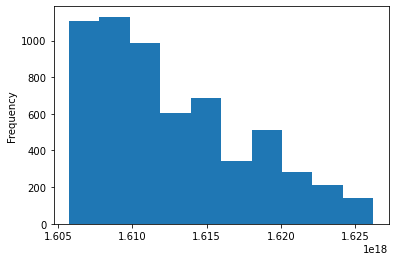

In [24]:
data[data['event'] == 'mint']['timestamp'].astype(int).plot.hist()

In [26]:
import pandas as pd
pd.read_csv("../uni-swap-graph")

In [33]:
data.groupby('event').size()

event
burn               77
ethPurchase      3111
mint               32
tokenPurchase    2889
dtype: int64

### To Do:

1. Genesis state methodology.

Minimum date

In [34]:
print(data.groupby('event')['timestamp'].min().min())

2021-07-06 14:47:29


In [ ]:
2021-07-06 15